In [1]:
%matplotlib inline
# Add the application folder to the path
import sys
sys.path.insert(0,'../Peergrade/peergrade/')

import application.model as data_model
from collections import defaultdict
import numpy as np
from bson.objectid import ObjectId
from matplotlib import pyplot as plt

SETUP LINK TO REDIS CACHE redis://localhost:6379
Initializing SAML...
Loading local database


In [32]:
class Grader_(object):
    def __init__(self, id):
        self.id = id
        self.handins = list()
        
    def add_handin(self, handin):
        self.handins.append(handin)

class Question_(object):
    def __init__(self,id):
        self.id = id

class Handin_(object):
    def __init__(self,id,owner):
        self.id = id
        self.owner = owner
        self.answers = dict()
        self.graders = list()
    
    def add_grader(self,grader):
        self.graders.append(grader)
        
    def add_answer(self,grader,question,value):
        if str(question.id) not in self.answers:
            self.answers[str(question.id)] = dict()
        self.answers[str(question.id)][str(grader.id)] = value
            
class Assignment_(object):
    
    def __init__(self, handins_input, graders_input, questions_input, n_gradings):
        self.graders = dict()
        self.handins = dict()
        self.questions = dict()
        self.n_gradings = n_gradings
        for handin in handins_input:
            self.handins[handin.id] = handin
        for grader in graders_input:
            self.graders[grader.id] = grader
        for question in questions_input:
            self.questions[question.id] = question

    
    def add_handin(self, handin):
        self.handing[handin.id] = handin
        
    def add_grader(self, grader):
        self.graders[grader.id] = grader
    
    def set_questions(self, questions):
        self.questions = list(questions)

            
#class Course(object):
#    
#    def __init__(self):
#        self.assignments = list()
#        self.handins = dict()
#        self.graders = dict()
#        self.n_gradings = 0
#    
#    def add_assignment(self,assignment):
#        self.assignments.append(assignment)
#        for a in self.assignments:
#            self.handins.update(a.handins)
#            self.graders.update(a.graders)
#        self.n_gradings = self.n_gradings + a.n_gradings

In [33]:
def user_name(user_id):
    user = data_model.User.objects.get(id=user_id)
    return user.name

def question_max_value(question):
    if question.question_type == "boolean":
        return 1
    elif question.question_type == "numerical":
        if question.numericalAnswers:
            max_value = max(map(int,question.numericalAnswers.keys()))
            return max_value
        else:
            return 5

def answer_value(answer):
    if answer.numerical_answer != None:
        return answer.numerical_answer / float(question_max_value(answer.question))
    if answer.boolean_answer != None:
        return answer.boolean_answer / float(question_max_value(answer.question))

def answeres_handin(report_grade):
    '''Returns a list of tuples containing the answer and the value of the question'''
    answers = data_model.Answer.objects(report_grade=report_grade)
    result = list()
    for answer in answers:
        if answer.text_answer == None:
            result.append((answer,answer_value(answer)))
    return result

In [34]:
def fetch_assignment_data(ass_obj):
    '''
    Takes an course and assignment data model object and transforms it into populated Assignment object
    Only student or all?
    '''

    print ass_obj.id
    
    ## Find all graders
    graders = dict()
    for student_ in ass_obj.course.students:
        graders[str(student_.id)] = Grader_(str(student_.id))

    ## Find all relevant question for the assignemnt
    questions = dict()
    for sec in ass_obj.sections:
        for question in sec.questions:
            if question.question_type != 'text':
                questions[str(question.id)] = Question_(str(question.id))
    
    ## Find all handins
    handins = dict()
    for handin_ in data_model.Handin.objects(assignment=ass_obj):
        handins[str(handin_.id)] = Handin_(str(handin_.id),str(handin_.submitter.id))    
        
    ## Find all handins graders have graded and vice versa
    n_gradings = 0
    for handin_ in data_model.Handin.objects(assignment=ass_obj):
        for grade in data_model.ReportGrade.objects(handin=handin_,state='ANSWERED'):
            
            n_gradings = n_gradings + 1
            
            # Needed if TA or Professor have graded reports as they are not initialy part of it
            if str(grade.giver.id) not in graders:
                graders[str(grade.giver.id)] = Grader_(str(grade.giver.id))
                
            handins[str(handin_.id)].add_grader(graders[str(grade.giver.id)])
            
            ## Find all answers to each question
            for answer, answer_value in answeres_handin(grade):
                if str(answer.question.id) in questions:
                    handins[str(handin_.id)].add_answer(grade.giver,answer.question,answer_value)
            
    ## update reference in graders
    for handin in handins.itervalues():
        for grader in handin.graders:
            grader.add_handin(handin)

    return Assignment_(handins.itervalues(),graders.itervalues(),questions.itervalues(),n_gradings)

In [35]:
c = data_model.Assignment.objects.get(title="UNIX, Python and Fast Data")

In [36]:
t = fetch_assignment_data(c)

55f277cff3bd61000a2112d4


In [128]:
def gibbs_model(data):
    
    # Counts
    N_H = len(data.handins) # Number of handins
    N_G = len(data.graders) # Number of graders
    N_g = data.n_gradings   # Number of gradings
    N_eval = N_g*N_G   # Number of evaluations in total
    
    # Hyperparameters
    ga_h = 0.5
    la_h = 1.0
    al_h = 10.0
    be_h = 0.1

    ga_g = 0.0
    la_g = 1.0
    al_g = 50.0
    be_g = 0.1
    
    al_e = 10.0
    be_e = 1.0
    t_h = 500.0
    t_g = 100.0
    
    # Prior parameters
    u_h = defaultdict(dict)
    t_h = defaultdict(dict)
    T = defaultdict(dict)
    u_g = dict()
    t_g = dict()
    B = dict()

    # Draw from priors
    e = np.random.gamma(al_e,1.0/be_e)
    for h, handin in data.handins.iteritems():
        for q in data.questions.iterkeys():
            t_h[h][q] = np.random.gamma(al_h,1.0/be_h)
            u_h[h][q] = np.random.normal(ga_h,np.sqrt(1.0/(la_g * t_h[h][q])))
            T[h][q] = np.random.normal(u_h[h][q],np.sqrt(1.0/t_h[h][q]))
    for g, grader in data.graders.iteritems():
        t_g[g] = np.random.gamma(al_g,1.0/be_g)
        u_g[g] = np.random.normal(ga_g,np.sqrt(1.0/(la_g * t_g[g])))
        B[g] = np.random.normal(u_g[g],np.sqrt(1.0/t_g[g]))

    # Gibbs sampling
    
    burn_in = 1000  # warm-up steps
    samples = 5000 # Gibbs sampling steps
    
    # Tracers initialising
    acc_e = 0
    acc_u_h = defaultdict(lambda: defaultdict(lambda : 0))
    acc_t_h = defaultdict(lambda: defaultdict(lambda : 0))
    acc_u_g = defaultdict(lambda : 0)
    acc_t_g = defaultdict(lambda : 0)
    acc_T = defaultdict(lambda: defaultdict(lambda : 0))
    acc_B = defaultdict(lambda : 0)

    for r in range(burn_in + samples):
        print "\r%i" % (r+1) + " out of %i" % (burn_in + samples),
        # Sample T
        for h, handin in data.handins.iteritems():
            for q, answer in handin.answers.iteritems():
                n_gradings = 0
                sum_ = 0.0
                for g, val in answer.iteritems():
                    n_gradings = n_gradings + 1
                    sum_ = sum_ + val - B[g]
                v = e*n_gradings+t_h[h][q]
                T[h][q] = np.random.normal((u_h[h][q]*t_h[h][q]+e*sum_)/v,np.sqrt(1/v))
            
        # Sample B
        for g, grader in data.graders.iteritems():
            n_gradings = 0
            sum_ = 0.0
            for h in grader.handins:
                for q, answer in h.answers.iteritems():
                    if g not in answer:
                        print h.id, q, g
                        print answer
                    n_gradings = n_gradings + 1
                    sum_ = sum_ + answer[g] - T[h.id][q]
            v = e * n_gradings + t_g[g]
            B[g] = np.random.normal((u_g[g]*t_g[g]+e*sum_)/v,np.sqrt(1/v))
        
        # Sample e
        sum_ = 0.0
        n_eval = 0
        for h, handin in data.handins.iteritems():
            for q, answers in handin.answers.iteritems():
                for g, answer_val in answers.iteritems():
                    n_eval = n_eval + 1
                    sum_ = sum_ + np.square(answer_val - (T[h][q]+B[g]))
        e = np.random.gamma(al_e+0.5*n_eval,1.0/(be_e+0.5*sum_))

        # Sample u_h and t_h
        for h, handin in data.handins.iteritems():
            for q in handin.answers.iterkeys():
                Q = len(handin.answers.keys())
                la_ = (la_h+1)
                al_ = al_h + 0.5 * la_h + 0.5 * np.square(T[h][q]-u_h[h][q])
                be_ = be_h + 0.5 + 0.5 * 1
    #            al_ = al_h+0.5
    #            be_ = be_h+0.5*((la_h*np.square(T[h]-ga_h))/la_)
                t_h[h][q] = np.random.gamma(al_,1.0/be_)
                u_h[h][q] = np.random.normal((la_h*ga_h+T[h][q])/la_,np.sqrt(1.0/(la_*t_h[h][q])))

        # Sample u_g and t_g
        for g in data.graders.iterkeys():
            la_ = (la_g+1)
            al_ = al_g + 0.5 * la_g + 0.5 * np.square(B[g]-u_g[g])
            be_ = be_g + 0.5 + 0.5 * 1
#            al_ = al_g+0.5
#            be_ = be_g+0.5*((la_g*np.square(B[g]-ga_g))/la_)
            t_g[g] = np.random.gamma(al_,1.0/be_)
            u_g[g] = np.random.normal((la_g*ga_g+B[g])/la_,np.sqrt(1.0/(t_g[g])))
            
        # Collect tracings
        if r > burn_in:
            acc_e = acc_e + e
            for h in data.handins.iterkeys():
                for q in data.questions.iterkeys():
                    acc_u_h[h][q] = acc_u_h[h][q] + u_h[h][q]
                    acc_t_h[h][q] = acc_t_h[h][q] + t_h[h][q]
                    acc_T[h][q] = acc_T[h][q] + T[h][q]
            for g in data.graders.iterkeys():
                acc_u_g[g] = acc_u_g[g] + u_g[g]
                acc_t_g[g] = acc_t_g[g] + t_g[g]
                acc_B[g] = acc_B[g] + B[g]    
    
    acc_e = acc_e / float(samples)
    for h in data.handins.iterkeys():
        for q in data.questions.iterkeys():
            acc_u_h[h][q] = acc_u_h[h][q] / float(samples)
            acc_t_h[h][q] = acc_t_h[h][q] / float(samples)
            acc_T[h][q] = acc_T[h][q] / float(samples)
    for g in data.graders.iterkeys():

        acc_u_g[g] = acc_u_g[g] / float(samples)
        acc_t_g[g] = acc_t_g[g] / float(samples)
        acc_B[g] = acc_B[g] / float(samples)
    
    traces = {'e' : acc_e,
              'u_h' : acc_u_h,
              't_h' : acc_t_h,
              'u_g' : acc_u_g,
              't_g' : acc_t_g,
              'T' : acc_T,
              'B' : acc_B}

    return traces

In [129]:
def plot_bias(t,result):
    scores = list()
    for id, g in t.graders.iteritems():
        scores.append((user_name(ObjectId(id)),result['B'][id]))

    ax = plt.subplot(111)

    scores.sort(key=lambda x:x[1])
    model_1 = map(lambda x : float(x[1]),scores)

    label = map(lambda x : x[0],scores)
    y = xrange(0,len(scores))
    plt.plot(model_1,y,'or',label="Gibbs sampling",alpha=0.65)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width+0.45, box.height*5])
    plt.yticks(xrange(0,len(scores)),label)
    plt.legend(loc=4)
    plt.vlines(0, 0, len(scores), color="k", linestyles="--", lw=1)
    plt.show()

In [130]:
def plot_handin_score(t,result):

    scores = list()
    for h, handin in t.handins.iteritems():
        for q in handin.answers.iterkeys():
            scores.append((q,result['T'][h][q],handin.answers[q].values()))
        break

    ax = plt.subplot(111)

    scores.sort(key=lambda x:x[1])
    model_1 = map(lambda x : float(x[1]),scores)
    mean = map(lambda x : x[2],scores)

    label = map(lambda x : x[0],scores)
    y = xrange(0,len(scores))
    plt.plot(model_1,y,'or',label="Gibbs sampling")
    plt.boxplot(mean, positions=y, vert=False)
#    plt.plot(mean,y,'ob',label="Mean",alpha=0.65)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width+0.45, box.height*4])
    plt.yticks(xrange(0,len(scores)),label)
    plt.legend(loc=4)
#    plt.xlim(0,1)
    plt.show()

In [131]:
def get_sorted_result(t,result):
    s = list()
    for name, g in t.graders.iteritems():
        s.append((user_name(ObjectId(name)),result['B'][name]))
    s.sort(key=lambda x:x[1])
    return s

## Assignment 1

In [132]:
a1 = data_model.Assignment.objects.get(title="UNIX, Python and Fast Data")

a1_data = fetch_assignment_data(a1)

a1_result = gibbs_model(a1_data)

55f277cff3bd61000a2112d4
6000 out of 6000


In [133]:
1.0 / a1_result['e']

0.04510145801772393

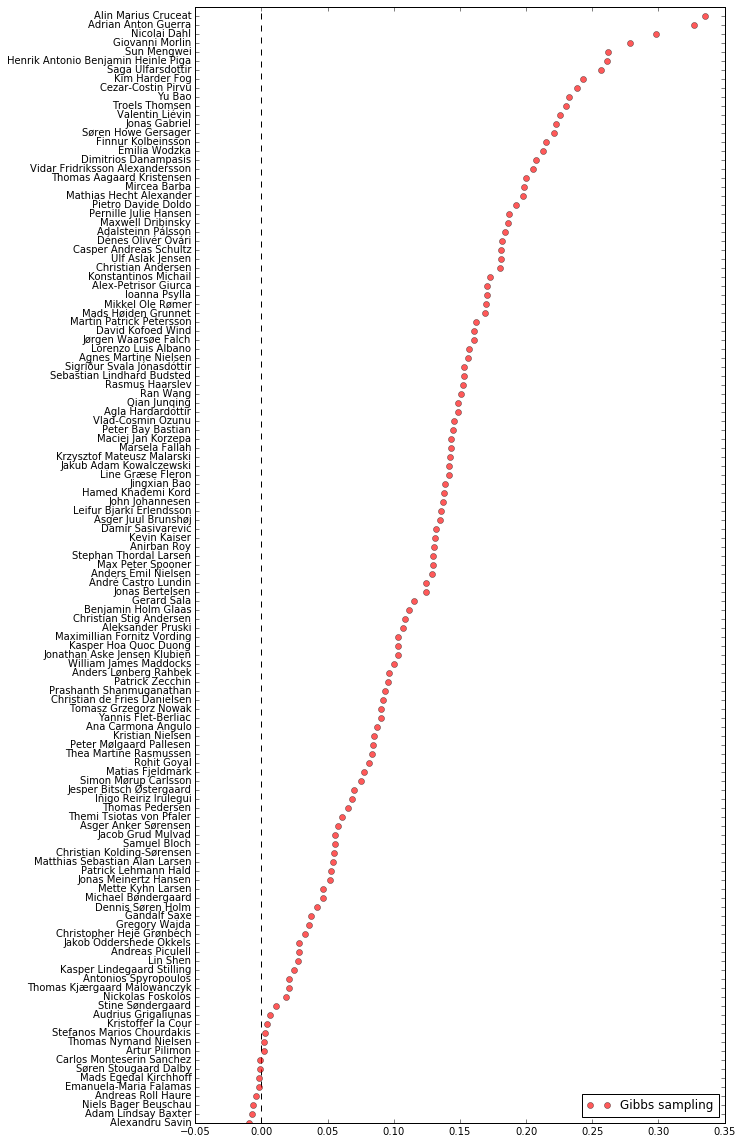

In [134]:
plot_bias(a1_data,a1_result)

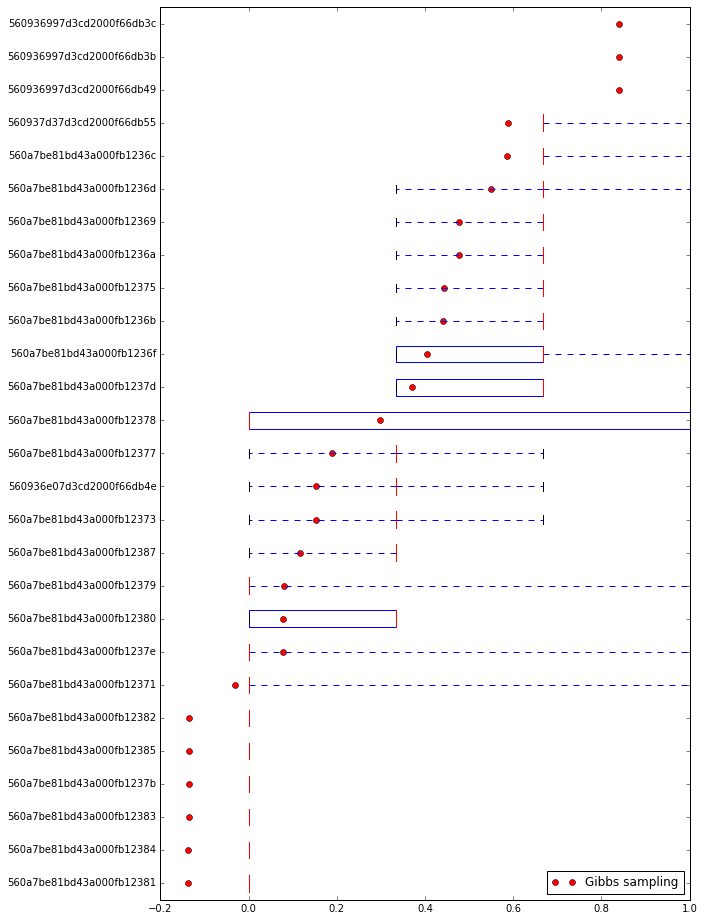

In [135]:
plot_handin_score(a1_data,a1_result)

## Assignment 2

In [ ]:
a2 = data_model.Assignment.objects.get(title="Databases and Streaming")

a2_data = fetch_data(a2)

a2_result = gibbs_model(a2_data)

In [ ]:
1.0 / a2_result['e']

In [ ]:
plot_bias(a2_data,a2_result)

In [ ]:
plot_handin_score(a2_data,a2_result)

## Assignment 3

In [ ]:
a3 = data_model.Assignment.objects.get(title="Big Data and Deep Learning")

a3_data = fetch_data(a3)

a3_result = gibbs_model(a3_data)

In [ ]:
1.0 / a3_result['e']

In [ ]:
plot_bias(a3_data,a3_result)

In [ ]:
sr = get_sorted_result(a3_data,a3_result)

In [ ]:
plot_handin_score(a3_data,a3_result)

## Assignment 4

In [ ]:
a4 = data_model.Assignment.objects.get(title="Your Choice of Subject")

a4_data = fetch_data(a4)

a4_result = gibbs_model(a4_data)

In [ ]:
1.0 / a4_result['e']

In [ ]:
plot_bias(a4_data,a4_result)

In [ ]:
plot_handin_score(a4_data,a4_result)

## closer look at  Jesper Bitcsh Østergaard

In [ ]:
sr = get_sorted_result(course_data,course_result)

for name, value in sr:
    if name == u'Jesper Bitsch \xd8stergaard':
        print name, value

In [ ]:
sr = get_sorted_result(a1_data,a1_result)

for name, value in sr:
    if name == u'Jesper Bitsch \xd8stergaard':
        print name, value

In [ ]:
sr = get_sorted_result(a2_data,a2_result)

for name, value in sr:
    if name == u'Jesper Bitsch \xd8stergaard':
        print name, value

In [ ]:
sr = get_sorted_result(a3_data,a3_result)

for name, value in sr:
    if name == u'Jesper Bitsch \xd8stergaard':
        print name, value

In [ ]:
sr = get_sorted_result(a4_data,a4_result)

for name, value in sr:
    if name == u'Jesper Bitsch \xd8stergaard':
        print name, value

The average of the bias over the 4 assignments

In [ ]:
((-0.18)+(-0.019)+(-0.11)+(-0.05))/4.0

It seems that the bias in assignment 4 have a very heavy influence on the bias of the entire course which is not ideal

## Closer look at André Castro Lundin

In [ ]:
sr = get_sorted_result(course_data,course_result)

for name, value in sr:
    if name == u'Andr\xe9 Castro Lundin':
        print name, value

In [ ]:
sr = get_sorted_result(a1_data,a1_result)

for name, value in sr:
    if name == u'Andr\xe9 Castro Lundin':
        print name, value

In [ ]:
sr = get_sorted_result(a2_data,a2_result)

for name, value in sr:
    if name == u'Andr\xe9 Castro Lundin':
        print name, value

In [ ]:
sr = get_sorted_result(a3_data,a3_result)

for name, value in sr:
    if name == u'Andr\xe9 Castro Lundin':
        print name, value

In [ ]:
sr = get_sorted_result(a4_data,a4_result)

for name, value in sr:
    if name == u'Andr\xe9 Castro Lundin':
        print name, value

The average of the bias over the 4 assignments

In [ ]:
((-0.0189)+(-0.035)+(-0.02)+(0.19))/4.0

The same as previously but this time it is in the positive direction

## Closer look at myself, Thomas Kjærgaard Malowanczyk

In [ ]:
sr = get_sorted_result(course_data,course_result)

for name, value in sr:
    if u'Thomas Kjærgaard Malowanczyk' in name:
        print name, value

In [ ]:
sr = get_sorted_result(a1_data,a1_result)

for name, value in sr:
    if u'Thomas Kjærgaard Malowanczyk' in name:
        print name, value

In [ ]:
sr = get_sorted_result(a2_data,a2_result)

for name, value in sr:
    if u'Thomas Kjærgaard Malowanczyk' in name:
        print name, value

In [ ]:
sr = get_sorted_result(a3_data,a3_result)

for name, value in sr:
    if u'Thomas Kjærgaard Malowanczyk' in name:
        print name, value

In [ ]:
sr = get_sorted_result(a4_data,a4_result)

for name, value in sr:
    if u'Thomas Kjærgaard Malowanczyk' in name:
        print name, value

The average of the bias over the 4 assignments

In [ ]:
((-0.0926)+(-0.000356)+(-0.139)+(-0.0799))/4.0

Here we see a more normal bias where I have received a negtive bias in most assignments. But the bias from the entore course is still lower than any of the bias in the assignments.

With this we can conclude that using MCMC on the entire course does not provide better result even though it provide more data.
The reson for the extreme result is hard to define as it is an unsubervised method so the underlying reasons in MCMC is not definable.
It can be assumed that taking MCMC over multiple assignments introduces more variables as each assignment can differe widely in both the subject, quality of the questions and the knowledge of the graders in both the subject and their abillity to grade.